# 1 Take home assignments

### Implement VAE on MNIST dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

torch.manual_seed(42)

# Hyperparameters
batch_size = 2048
latent_dim = 20 
learning_rate = 1e-3
num_epochs = 100
img_size = 28

transform = transforms.Compose([
    transforms.ToTensor(),
])

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 1),
            nn.MaxPool2d(2),  # 256x4x4 output
            nn.ReLU(),
            nn.Flatten()
        )

        # Assuming the flattened encoder output is (256 * 4 * 4) = 4096
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 4096)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 4, 4)),
            nn.Upsample(scale_factor=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 1),
            nn.Upsample(scale_factor=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, 1),
            nn.Sigmoid()                       
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)

        z = self.reparameterize(mu, logvar)

        # Decoding
        decoded = self.fc_dec(z)
        decoded = self.decoder(decoded)
        return decoded, mu, logvar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') / recon_x.size(0)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / recon_x.size(0)
    return BCE + KLD

# Load MNIST dataset
mnist_dataset = torchvision.datasets.MNIST(root='./mnist', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch%20 == 0:
      print(f'Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.4f}')
      # Save model
      torch.save(model.state_dict(), f'vae_mnist_{epoch}.pth')

# Generate samples
model.eval()
with torch.no_grad():
    sample = torch.randn(16, latent_dim).to(device)
    generated = model.decoder(model.fc_dec(sample)).cpu()

# Save generated images
torchvision.utils.save_image(generated, 'vae_mnist_samples.png', normalize=True, nrow=4)

print("Training complete. Generated samples saved as 'vae_mnist_samples.png'.")

Epoch 1, Loss: 0.1522
Epoch 21, Loss: 0.0521
Epoch 41, Loss: 0.0499
Epoch 61, Loss: 0.0491
Epoch 81, Loss: 0.0485
Training complete. Generated samples saved as 'vae_mnist_samples.png'.


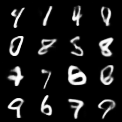

In [ ]:
from IPython.display import Image
Image('vae_mnist_samples.png')

# 2 Programming - Use Pytorch/TF library

## 2.1 Variational Autoencoder

### 1. Implement basic VAE on celebA faces dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import zipfile

torch.manual_seed(42)

# Hyperparameters
batch_size = 128
latent_dim = 100
learning_rate = 1e-3
num_epochs = 500
img_size = (64, 64)

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# model.load_state_dict(torch.load('vae_celeba.pth'))

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') / recon_x.size(0)  # Normalizing the loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

class CelebADataset(Dataset):
    def __init__(self, img_dir, partition_file, transform=None, partition=0):
        self.img_dir = img_dir
        self.partition_file = partition_file
        self.transform = transform
        self.partition = partition

        # Load partition info
        self.partitions = pd.read_csv(partition_file, header=None, names=['image', 'partition']).drop(0).astype({'partition': 'int16'})
        self.partitions = self.partitions[self.partitions['partition'] == self.partition]

    def __len__(self):
        return len(self.partitions)

    def __getitem__(self, idx):
        img_name = self.partitions.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, 0 


celeba_img_folder = '/home/sie/Documents/gen_ai_assignment/archive/img_align_celeba'
partition_file = '/home/sie/Documents/gen_ai_assignment/archive/list_eval_partition.csv'

# Ensure the dataset folder exists
if not os.path.exists(celeba_img_folder):
    raise FileNotFoundError(f"The directory '{celeba_img_folder}' does not exist. Ensure dataset is downloaded correctly.")

# Create dataset objects for train, validation, and test
train_dataset = CelebADataset(img_dir=celeba_img_folder, partition_file=partition_file, transform=transform, partition=0)
val_dataset = CelebADataset(img_dir=celeba_img_folder, partition_file=partition_file, transform=transform, partition=1)
test_dataset = CelebADataset(img_dir=celeba_img_folder, partition_file=partition_file, transform=transform, partition=2)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # if batch_idx % 1500 == 0:
        #     break

    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

torch.save(model.state_dict(), 'vae_celeba.pth')

# Generate samples
model.eval()
with torch.no_grad():
    sample = torch.randn(64, latent_dim).to(device)
    generated = model.decode(sample).cpu()

# Save generated images
torchvision.utils.save_image(generated, 'vae_samples.png', normalize=True, nrow=8)

print("Training complete. Generated samples saved as 'vae_samples.png'.")


Epoch 1, Loss: 0.0530
Epoch 2, Loss: 0.0525
Epoch 3, Loss: 0.0516
Epoch 4, Loss: 0.0502
Epoch 5, Loss: 0.0480
Epoch 6, Loss: 0.0450
Epoch 7, Loss: 0.0404
Epoch 8, Loss: 0.0339
Epoch 9, Loss: 0.0258
Epoch 10, Loss: 0.0140
Epoch 11, Loss: 0.0056
Epoch 12, Loss: -0.0165
Epoch 13, Loss: -0.0409
Epoch 14, Loss: -0.0974
Epoch 15, Loss: -0.2161
Epoch 16, Loss: -0.3767
Epoch 17, Loss: -0.6991
Epoch 18, Loss: -0.8694
Epoch 19, Loss: -1.0377
Epoch 20, Loss: -0.8122
Epoch 21, Loss: -0.9605
Epoch 22, Loss: -1.0560
Epoch 23, Loss: -0.8547
Epoch 24, Loss: -0.9755
Epoch 25, Loss: -0.8820
Epoch 26, Loss: -0.7723
Epoch 27, Loss: -0.6627
Epoch 28, Loss: -0.7291
Epoch 29, Loss: -1.0852
Epoch 30, Loss: -1.0087
Epoch 31, Loss: -1.0250
Epoch 32, Loss: -0.9891
Epoch 33, Loss: -1.1659
Epoch 34, Loss: -1.1493
Epoch 35, Loss: -1.2198
Epoch 36, Loss: -1.3464
Epoch 37, Loss: -1.1842
Epoch 38, Loss: -1.3797
Epoch 39, Loss: -1.3136
Epoch 40, Loss: -1.5400
Epoch 41, Loss: -1.3268
Epoch 42, Loss: -1.5113
Epoch 43, Lo

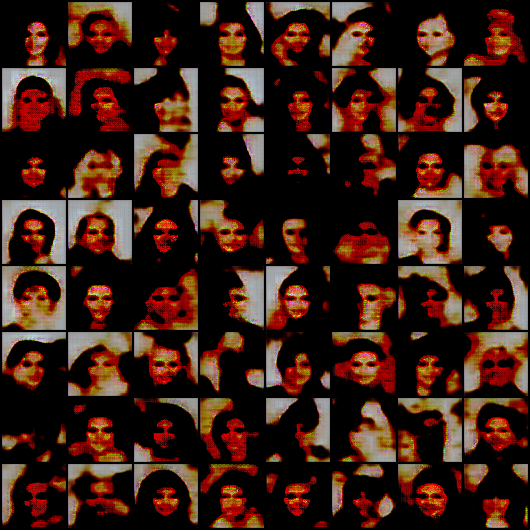

In [ ]:
# Generated samples are
from IPython.display import Image
Image(filename='vae_samples.png')

### 2. Latent Space arithmetic - Make your image smile. Generate smiling face images by playing with latent space z vector.

In [ ]:
import numpy as np
from PIL import Image

# Load the attribute labels
attribute_file = './archive/list_attr_celeba.csv'
attributes = pd.read_csv(attribute_file)

# Select the "Smiling" attribute
smiling_imgs = attributes[attributes['Smiling'] == 1]['image_id'].values
not_smiling_imgs = attributes[attributes['Smiling'] == -1]['image_id'].values

def compute_average_embedding(model, img_dir, img_list, transform):
    embeddings = []
    model.eval()

    with torch.no_grad():
        for img_name in img_list:
            img_path = os.path.join(img_dir, img_name)
            image = Image.open(img_path)
            image = transform(image).unsqueeze(0).to(device)

            mu, logvar = model.encode(image)
            z = model.reparameterize(mu, logvar)
            embeddings.append(z.cpu().numpy())

    embeddings = np.array(embeddings)
    avg_embedding = np.mean(embeddings, axis=0)
    return avg_embedding

# Compute smile and no-smile embeddings
smiling_avg_embedding = compute_average_embedding(model, celeba_img_folder, smiling_imgs, transform)
not_smiling_avg_embedding = compute_average_embedding(model, celeba_img_folder, not_smiling_imgs, transform)

smile_vector = smiling_avg_embedding - not_smiling_avg_embedding

def add_smile(model, img, smile_vector, alpha=1.0):
    model.eval()
    with torch.no_grad():
        # Encode the image
        img = img.unsqueeze(0).to(device)
        mu, logvar = model.encode(img)
        z = model.reparameterize(mu, logvar)

        # Modify the latent space by adding the smile vector
        z_smile = z + alpha * torch.from_numpy(smile_vector).to(device)

        # Decode the modified latent vector
        img_smile = model.decode(z_smile)

    return img_smile

# Load and manipulate a test image
img_path = 'non_smiling.jpg'
test_img = transform(Image.open(img_path)).to(device)
img_with_smile = add_smile(model, test_img, smile_vector, alpha=1.0)

# Save the generated smiling image
torchvision.utils.save_image(img_with_smile, 'smiling_image.png', normalize=True)

# Generate a more intense smile
img_with_big_smile = add_smile(model, test_img, smile_vector, alpha=2.0)
torchvision.utils.save_image(img_with_big_smile, 'big_smile_image.png', normalize=True)


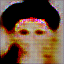

In [ ]:
# Generated smiling image
from IPython.display import Image
Image('smiling_image.png')

## 2.2 Variants of GANs



### 1. Implement a standard GAN on MNIST/CIFAR-10 data. Plot Generator loss, Discriminator Loss and Classification accuracy of discriminator with respect to iterations.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
hidden_dim = 256
image_dim = 28*28
batch_size = 64
num_epochs = 100
learning_rate = 0.0002

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=False)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, image_dim),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
adversarial_loss = nn.BCELoss()

# Training loop
G_losses = []
D_losses = []
D_accuracies = []

for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Calculate discriminator accuracy
        d_real_accuracy = (discriminator(real_imgs) > 0.5).float().mean().item()
        d_fake_accuracy = (discriminator(gen_imgs.detach()) <= 0.5).float().mean().item()
        d_accuracy = (d_real_accuracy + d_fake_accuracy) / 2

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        D_accuracies.append(d_accuracy)

    print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
           f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
           f"[D accuracy: {d_accuracy:.4f}]")

torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

# Plot losses and accuracy
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(D_accuracies, label='Discriminator Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.title('GAN Training Progress')
plt.savefig('gan_training_progress.png')
plt.close()

print("Training complete. Progress plot saved as 'gan_training_progress.png'.")

n_samples = 16
z = torch.randn(n_samples, latent_dim).to(device)
gen_imgs = generator(z).detach().cpu()

grid = torchvision.utils.make_grid(gen_imgs, nrow=4, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.savefig('gan_generated_samples.png')
plt.close()

print("Sample images generated and saved as 'gan_generated_samples.png'.")

[Epoch 0/100] [Batch 937/938] [D loss: 0.0159] [G loss: 3.8533] [D accuracy: 1.0000]
[Epoch 1/100] [Batch 937/938] [D loss: 0.1070] [G loss: 2.4122] [D accuracy: 0.9688]
[Epoch 2/100] [Batch 937/938] [D loss: 0.3842] [G loss: 1.5592] [D accuracy: 0.9219]
[Epoch 3/100] [Batch 937/938] [D loss: 0.1589] [G loss: 2.1942] [D accuracy: 0.9531]
[Epoch 4/100] [Batch 937/938] [D loss: 0.0753] [G loss: 4.5895] [D accuracy: 0.9844]
[Epoch 5/100] [Batch 937/938] [D loss: 0.1489] [G loss: 4.3297] [D accuracy: 0.9688]
[Epoch 6/100] [Batch 937/938] [D loss: 0.2573] [G loss: 2.9687] [D accuracy: 0.9375]
[Epoch 7/100] [Batch 937/938] [D loss: 0.0965] [G loss: 6.1343] [D accuracy: 0.9688]
[Epoch 8/100] [Batch 937/938] [D loss: 0.0945] [G loss: 2.8061] [D accuracy: 0.9844]
[Epoch 9/100] [Batch 937/938] [D loss: 0.2093] [G loss: 5.0216] [D accuracy: 0.9531]
[Epoch 10/100] [Batch 937/938] [D loss: 0.0917] [G loss: 4.2588] [D accuracy: 0.9688]
[Epoch 11/100] [Batch 937/938] [D loss: 0.1860] [G loss: 4.6545]

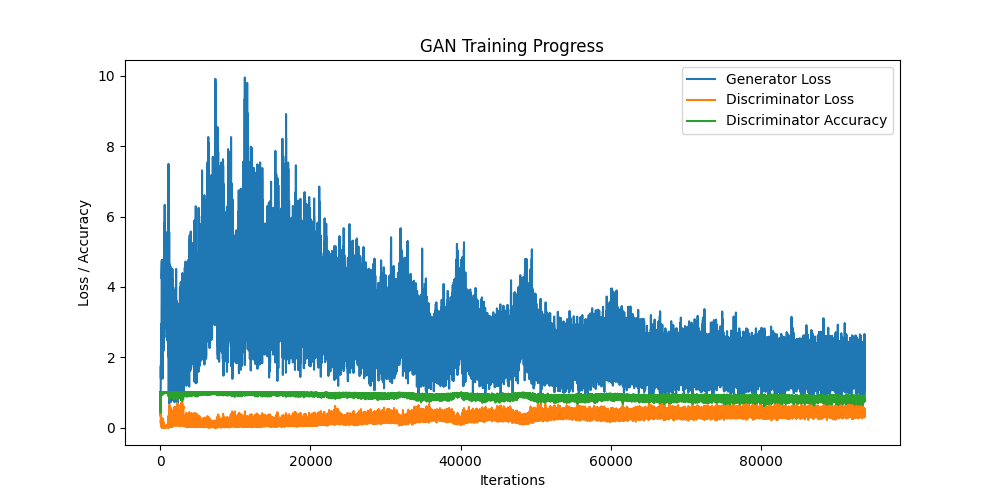

In [ ]:
from IPython.display import Image
Image('gan_training_progress.png')

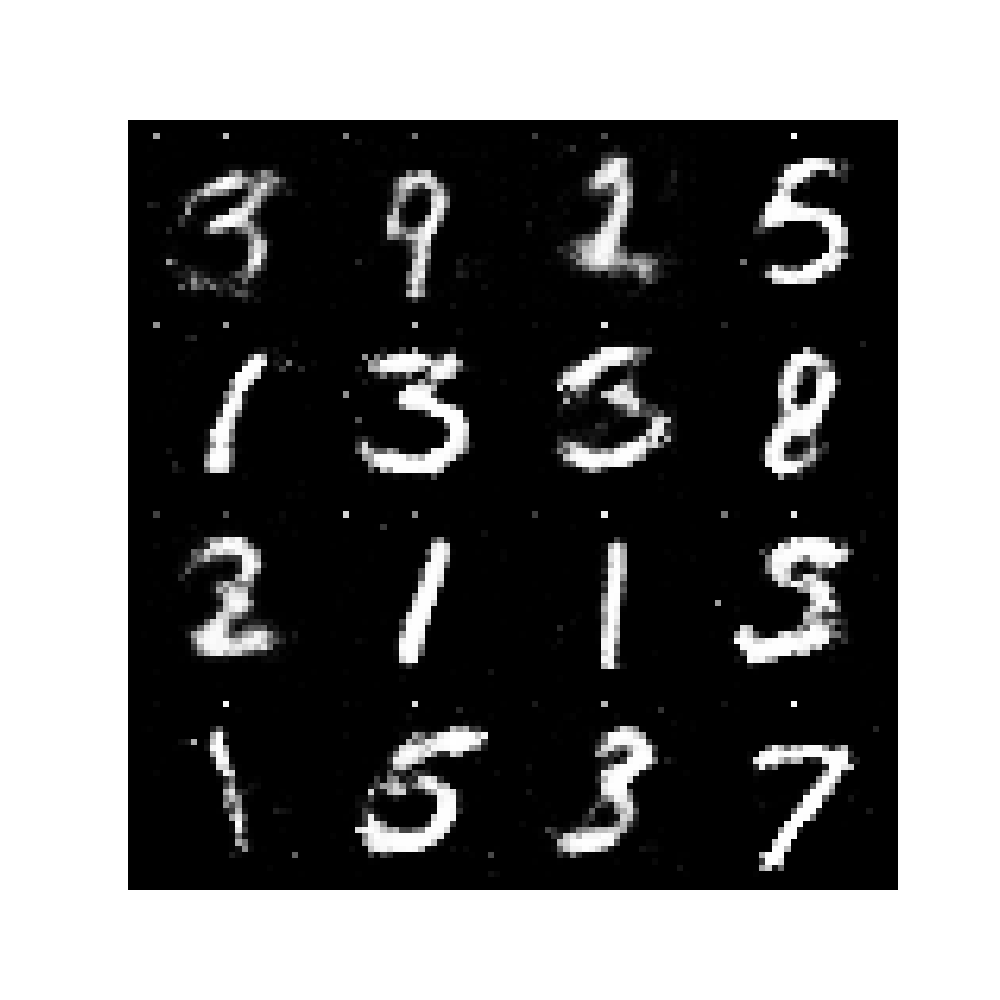

In [ ]:
Image('gan_generated_samples.png')

### 2. Demonstrate the vanishing gradient problem of standard GAN by training your GAN for 5,10 and 25 epochs. Then stop the GAN training, train only the discriminator till it reaches 100% accuracy and then use this perfect discriminator to train your GAN. Plot the generator loss/gradient norm and discriminator loss w.r.t epochs (using your perfect discriminator).

[Epoch 0/5] [Batch 234/235] [D loss: 0.0144] [G loss: 3.9575] [D accuracy: 1.0000]
[Epoch 1/5] [Batch 234/235] [D loss: 0.0401] [G loss: 3.6167] [D accuracy: 0.9844]
[Epoch 2/5] [Batch 234/235] [D loss: 0.0328] [G loss: 4.1372] [D accuracy: 0.9948]
[Epoch 3/5] [Batch 234/235] [D loss: 0.0226] [G loss: 4.1470] [D accuracy: 0.9948]
[Epoch 4/5] [Batch 234/235] [D loss: 0.1277] [G loss: 3.7552] [D accuracy: 0.9844]
[Epoch 0/10] [Batch 234/235] [D loss: 0.0364] [G loss: 3.2813] [D accuracy: 1.0000]
[Epoch 1/10] [Batch 234/235] [D loss: 0.1341] [G loss: 3.2018] [D accuracy: 0.9792]
[Epoch 2/10] [Batch 234/235] [D loss: 0.1045] [G loss: 3.2027] [D accuracy: 0.9688]
[Epoch 3/10] [Batch 234/235] [D loss: 0.1653] [G loss: 2.5413] [D accuracy: 0.9688]
[Epoch 4/10] [Batch 234/235] [D loss: 0.2955] [G loss: 2.0764] [D accuracy: 0.9375]
[Epoch 5/10] [Batch 234/235] [D loss: 0.2134] [G loss: 3.1298] [D accuracy: 0.9531]
[Epoch 6/10] [Batch 234/235] [D loss: 0.3673] [G loss: 1.8452] [D accuracy: 0.942

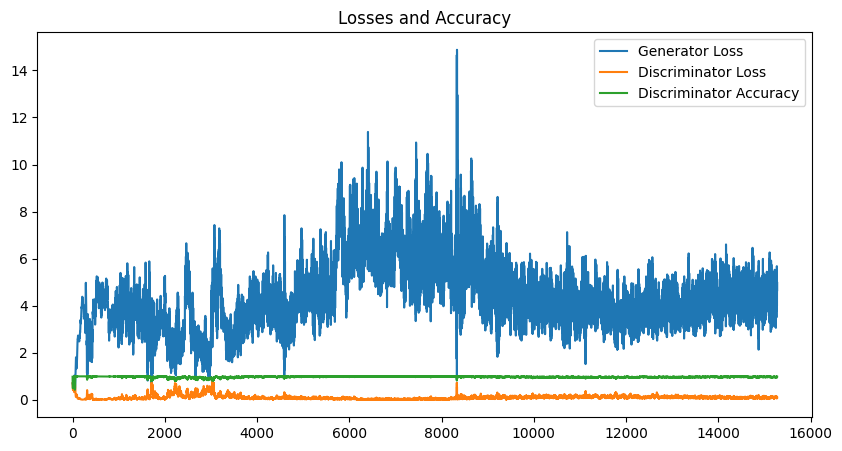

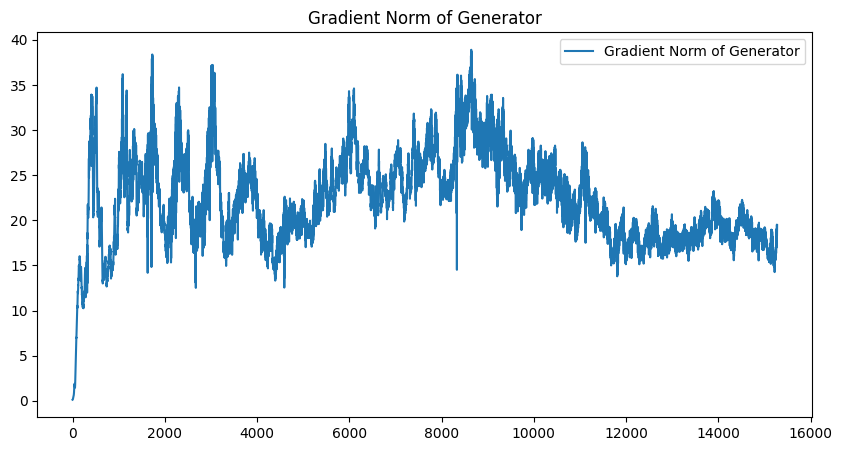

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
hidden_dim = 256
image_dim = 28*28
batch_size = 256
num_epochs = [5, 10, 25] 
learning_rate = 0.0002

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=False)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, image_dim),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
adversarial_loss = nn.BCELoss()

G_losses = []
D_losses = []
D_accuracies = []
grad_norms = []

def train_gan(num_epochs):
    for epoch in range(num_epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # Ground truths
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
            g_loss.backward()

            grad_norm = torch.norm(torch.cat([p.grad.view(-1) for p in generator.parameters()]))
            grad_norms.append(grad_norm.item())

            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Calculate discriminator accuracy
            d_real_accuracy = (discriminator(real_imgs) > 0.5).float().mean().item()
            d_fake_accuracy = (discriminator(gen_imgs.detach()) <= 0.5).float().mean().item()
            d_accuracy = (d_real_accuracy + d_fake_accuracy) / 2

            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            D_accuracies.append(d_accuracy)

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
              f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
              f"[D accuracy: {d_accuracy:.4f}]")

# Train GAN for 5, 10, and 25 epochs separately 
for epoch in num_epochs:
    train_gan(epoch)

def train_discriminator_only():
    for epoch in range(10):  
        for real_imgs, _ in dataloader:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z).detach()

            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            d_real_accuracy = (discriminator(real_imgs) > 0.5).float().mean().item()
            d_fake_accuracy = (discriminator(gen_imgs) <= 0.5).float().mean().item()
            d_accuracy = (d_real_accuracy + d_fake_accuracy) / 2

            if d_accuracy == 1.0:  # Stop when 100% accuracy is achieved
                print("Discriminator reached 100% accuracy!")
                return

train_discriminator_only()

train_gan(25)

# Plot losses and accuracy
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.plot(D_accuracies, label="Discriminator Accuracy")
plt.title("Losses and Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(grad_norms, label="Gradient Norm of Generator")
plt.title("Gradient Norm of Generator")
plt.legend()
plt.show()


### 3. Implement WGAN (with weight clipping strategy) and WGAN-GP (Gradient penalty) with Cifar-10 dataset. Plot the generator loss and discriminator loss w.r.t epochs.

Files already downloaded and verified
[WGAN] [Epoch 1/20] [D loss: -1.8016] [G loss: 3.6559]
[WGAN] [Epoch 2/20] [D loss: 0.4569] [G loss: 6.5473]
[WGAN] [Epoch 3/20] [D loss: -6.8577] [G loss: -3.6527]
[WGAN] [Epoch 4/20] [D loss: -8.8208] [G loss: 18.6705]
[WGAN] [Epoch 5/20] [D loss: -8.0744] [G loss: 1.0301]
[WGAN] [Epoch 6/20] [D loss: -4.9336] [G loss: 1.6088]
[WGAN] [Epoch 7/20] [D loss: -9.1072] [G loss: -1.8450]
[WGAN] [Epoch 8/20] [D loss: -9.3230] [G loss: 5.2087]
[WGAN] [Epoch 9/20] [D loss: -11.2970] [G loss: 8.5238]
[WGAN] [Epoch 10/20] [D loss: -8.2480] [G loss: 7.4013]
[WGAN] [Epoch 11/20] [D loss: -7.6190] [G loss: -2.0563]
[WGAN] [Epoch 12/20] [D loss: -10.8375] [G loss: 2.1927]
[WGAN] [Epoch 13/20] [D loss: -7.8534] [G loss: 5.5149]
[WGAN] [Epoch 14/20] [D loss: -5.5890] [G loss: 2.8620]
[WGAN] [Epoch 15/20] [D loss: -9.1929] [G loss: 1.4552]
[WGAN] [Epoch 16/20] [D loss: -8.9392] [G loss: -0.2418]
[WGAN] [Epoch 17/20] [D loss: -5.3524] [G loss: 0.5674]
[WGAN] [Epoch

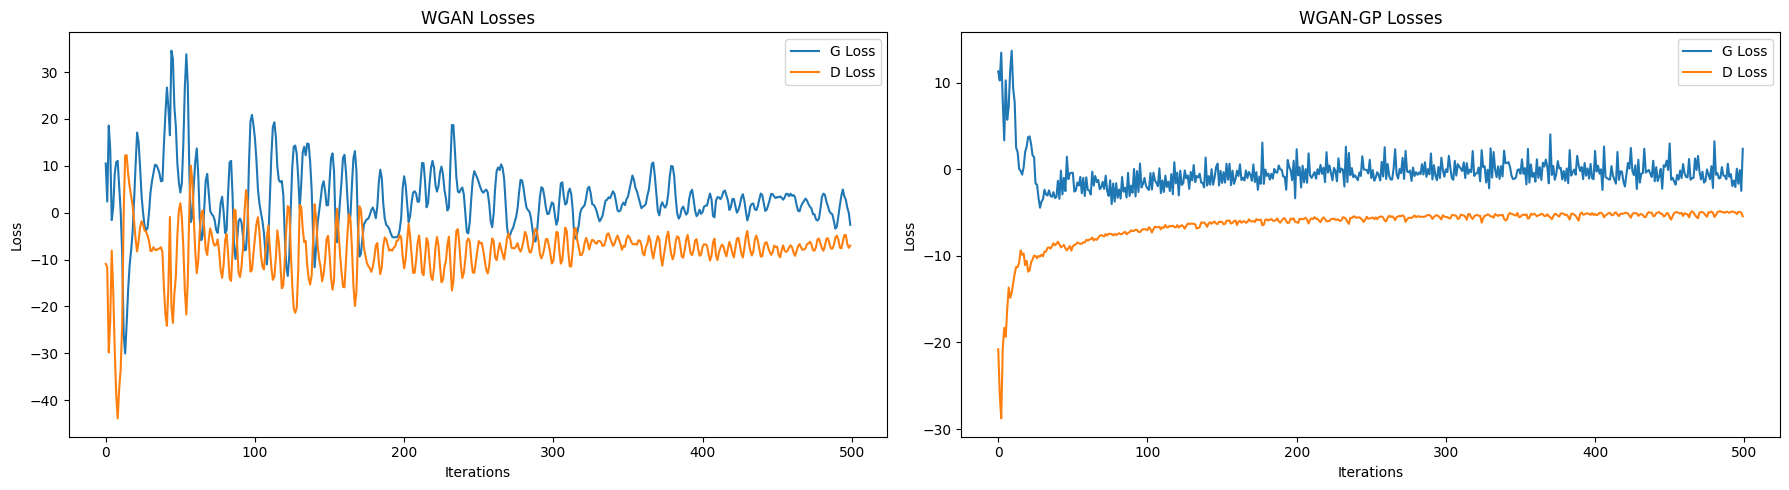

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
hidden_dim = 128
image_channels = 3
image_size = 32
batch_size = 2048
num_epochs = 20
learning_rate = 0.0002 
weight_clip = 0.01
n_critic = 5
lambda_gp = 10

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*image_channels, [0.5]*image_channels)
])

dataset = datasets.CIFAR10(root='cifar', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.BatchNorm1d(hidden_dim * 8),
            nn.ReLU(),
            nn.Linear(hidden_dim * 8, image_channels * image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), image_channels, image_size, image_size)

class Discriminator(nn.Module):
    def __init__(self, use_sn=False):
        super(Discriminator, self).__init__()
        if use_sn:
            self.model = nn.Sequential(
                spectral_norm(nn.Linear(image_channels * image_size * image_size, hidden_dim * 8)),
                nn.LeakyReLU(0.2),
                spectral_norm(nn.Linear(hidden_dim * 8, hidden_dim * 4)),
                nn.LeakyReLU(0.2),
                spectral_norm(nn.Linear(hidden_dim * 4, 1))
            )
        else:
            self.model = nn.Sequential(
                nn.Linear(image_channels * image_size * image_size, hidden_dim * 8),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim * 8, hidden_dim * 4),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim * 4, 1)
            )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

def gradient_penalty(discriminator, real_imgs, fake_imgs):
    alpha = torch.rand(real_imgs.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(real_imgs.size(0), 1).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_gan(gan_type="wgan"):
    generator = Generator().to(device)
    discriminator = Discriminator(use_sn=(gan_type=="sngan")).to(device)

    if gan_type == "sngan":
        optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))
        optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.0, 0.9))
        criterion = nn.BCEWithLogitsLoss()
    else:
        optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
        optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

    G_losses = []
    D_losses = []

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)

            for _ in range(n_critic):
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                if gan_type == "wgan":
                    loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))
                elif gan_type == "wgan-gp":
                    real_validity = discriminator(real_imgs)
                    fake_validity = discriminator(fake_imgs)
                    gp = gradient_penalty(discriminator, real_imgs, fake_imgs)
                    loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
                else: 
                    real_validity = discriminator(real_imgs)
                    fake_validity = discriminator(fake_imgs)
                    loss_real = criterion(real_validity, torch.ones_like(real_validity))
                    loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity))
                    loss_D = loss_real + loss_fake

                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

                if gan_type == "wgan":
                    for p in discriminator.parameters():
                        p.data.clamp_(-weight_clip, weight_clip)

            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)

            if gan_type == "sngan":
                fake_validity = discriminator(gen_imgs)
                loss_G = criterion(fake_validity, torch.ones_like(fake_validity))
            else:
                loss_G = -torch.mean(discriminator(gen_imgs))

            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

        print(f"[{gan_type.upper()}] [Epoch {epoch+1}/{num_epochs}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

    return G_losses, D_losses

# Train WGAN
wgan_G_losses, wgan_D_losses = train_gan("wgan")

# Train WGAN-GP
wgan_gp_G_losses, wgan_gp_D_losses = train_gan("wgan-gp")

# Plot losses
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(wgan_G_losses, label="G Loss")
plt.plot(wgan_D_losses, label="D Loss")
plt.title("WGAN Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(wgan_gp_G_losses, label="G Loss")
plt.plot(wgan_gp_D_losses, label="D Loss")
plt.title("WGAN-GP Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### 4. Implement SNGAN framework too with Cifar-10 dataset.

Files already downloaded and verified
[SNGAN] [Epoch 1/20] [D loss: 0.1994] [G loss: 2.3422]
[SNGAN] [Epoch 2/20] [D loss: 0.3186] [G loss: 1.6344]
[SNGAN] [Epoch 3/20] [D loss: 0.4953] [G loss: 2.0589]
[SNGAN] [Epoch 4/20] [D loss: 0.5471] [G loss: 1.5974]
[SNGAN] [Epoch 5/20] [D loss: 0.5994] [G loss: 1.4895]
[SNGAN] [Epoch 6/20] [D loss: 0.8523] [G loss: 1.3101]
[SNGAN] [Epoch 7/20] [D loss: 0.7954] [G loss: 1.2098]
[SNGAN] [Epoch 8/20] [D loss: 0.8724] [G loss: 1.0855]
[SNGAN] [Epoch 9/20] [D loss: 0.9771] [G loss: 1.0815]
[SNGAN] [Epoch 10/20] [D loss: 0.8760] [G loss: 1.2004]
[SNGAN] [Epoch 11/20] [D loss: 0.8820] [G loss: 1.0571]
[SNGAN] [Epoch 12/20] [D loss: 0.8847] [G loss: 1.0727]
[SNGAN] [Epoch 13/20] [D loss: 0.9425] [G loss: 1.0759]
[SNGAN] [Epoch 14/20] [D loss: 0.9560] [G loss: 1.0255]
[SNGAN] [Epoch 15/20] [D loss: 0.9511] [G loss: 1.0550]
[SNGAN] [Epoch 16/20] [D loss: 0.9042] [G loss: 1.2685]
[SNGAN] [Epoch 17/20] [D loss: 0.9459] [G loss: 0.9778]
[SNGAN] [Epoch 18/2

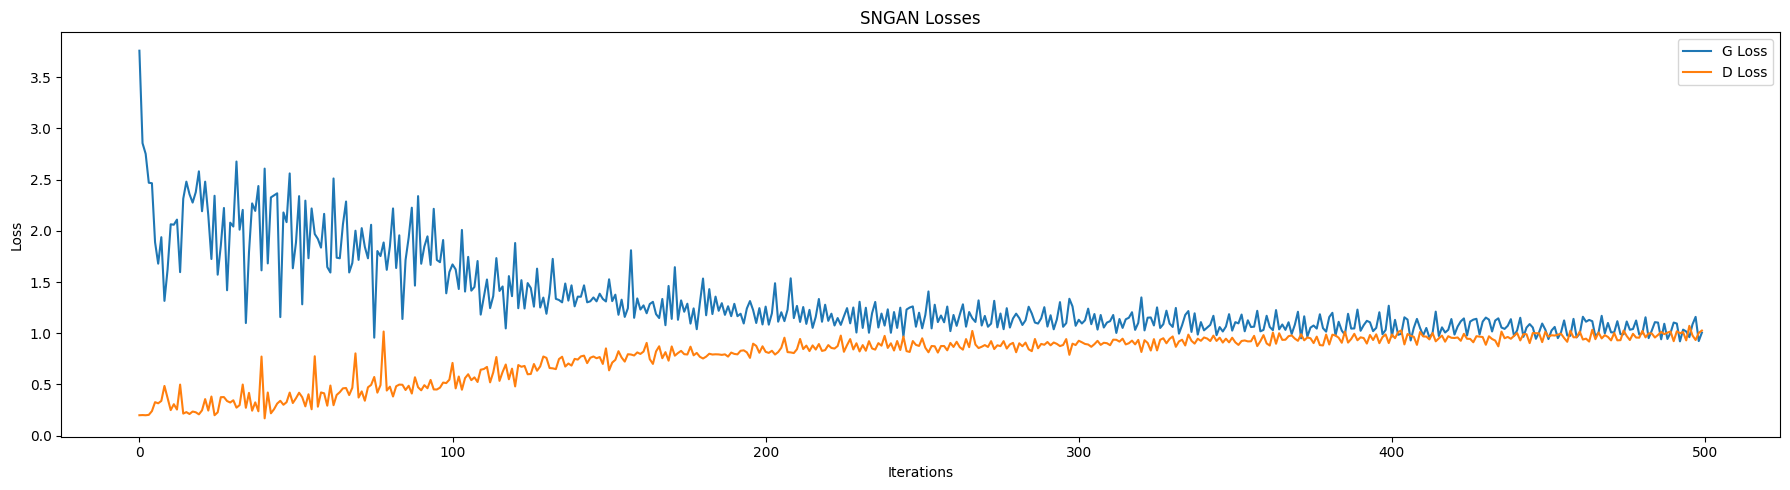

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
hidden_dim = 128
image_channels = 3
image_size = 32
batch_size = 2048
num_epochs = 20
learning_rate = 0.0002 
weight_clip = 0.01
n_critic = 5
lambda_gp = 10

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*image_channels, [0.5]*image_channels)
])

dataset = datasets.CIFAR10(root='cifar', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.BatchNorm1d(hidden_dim * 8),
            nn.ReLU(),
            nn.Linear(hidden_dim * 8, image_channels * image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), image_channels, image_size, image_size)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, use_sn=False):
        super(Discriminator, self).__init__()
        if use_sn:
            self.model = nn.Sequential(
                spectral_norm(nn.Linear(image_channels * image_size * image_size, hidden_dim * 8)),
                nn.LeakyReLU(0.2),
                spectral_norm(nn.Linear(hidden_dim * 8, hidden_dim * 4)),
                nn.LeakyReLU(0.2),
                spectral_norm(nn.Linear(hidden_dim * 4, 1))
            )
        else:
            self.model = nn.Sequential(
                nn.Linear(image_channels * image_size * image_size, hidden_dim * 8),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim * 8, hidden_dim * 4),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim * 4, 1)
            )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

def gradient_penalty(discriminator, real_imgs, fake_imgs):
    alpha = torch.rand(real_imgs.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(real_imgs.size(0), 1).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_gan(gan_type="wgan"):
    generator = Generator().to(device)
    discriminator = Discriminator(use_sn=(gan_type=="sngan")).to(device)

    if gan_type == "sngan":
        optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))
        optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.0, 0.9))
        criterion = nn.BCEWithLogitsLoss()
    else:
        optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
        optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

    G_losses = []
    D_losses = []

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)

            # Train Discriminator
            for _ in range(n_critic):
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                if gan_type == "wgan":
                    loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))
                elif gan_type == "wgan-gp":
                    real_validity = discriminator(real_imgs)
                    fake_validity = discriminator(fake_imgs)
                    gp = gradient_penalty(discriminator, real_imgs, fake_imgs)
                    loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
                else:  # SNGAN
                    real_validity = discriminator(real_imgs)
                    fake_validity = discriminator(fake_imgs)
                    loss_real = criterion(real_validity, torch.ones_like(real_validity))
                    loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity))
                    loss_D = loss_real + loss_fake

                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

                if gan_type == "wgan":
                    # Weight clipping for original WGAN
                    for p in discriminator.parameters():
                        p.data.clamp_(-weight_clip, weight_clip)

            # Train Generator
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)

            if gan_type == "sngan":
                fake_validity = discriminator(gen_imgs)
                loss_G = criterion(fake_validity, torch.ones_like(fake_validity))
            else:
                loss_G = -torch.mean(discriminator(gen_imgs))

            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

        print(f"[{gan_type.upper()}] [Epoch {epoch+1}/{num_epochs}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

    return G_losses, D_losses

sngan_G_losses, sngan_D_losses = train_gan("sngan")

# Plot losses
plt.figure(figsize=(18, 5))
plt.plot(sngan_G_losses, label="G Loss")
plt.plot(sngan_D_losses, label="D Loss")
plt.title("SNGAN Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### 5. Observe and Compare the time complexity of SN-GAN and WGAN-GP.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
hidden_dim = 128
image_channels = 3
image_size = 32
batch_size = 8192
num_epochs = 10
learning_rate = 0.0002  
weight_clip = 0.01
n_critic = 5
lambda_gp = 10

# CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*image_channels, [0.5]*image_channels)
])

dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.BatchNorm1d(hidden_dim * 8),
            nn.ReLU(),
            nn.Linear(hidden_dim * 8, image_channels * image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), image_channels, image_size, image_size)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, use_sn=False):
        super(Discriminator, self).__init__()
        if use_sn:
            self.model = nn.Sequential(
                spectral_norm(nn.Linear(image_channels * image_size * image_size, hidden_dim * 8)),
                nn.LeakyReLU(0.2),
                spectral_norm(nn.Linear(hidden_dim * 8, hidden_dim * 4)),
                nn.LeakyReLU(0.2),
                spectral_norm(nn.Linear(hidden_dim * 4, 1))
            )
        else:
            self.model = nn.Sequential(
                nn.Linear(image_channels * image_size * image_size, hidden_dim * 8),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim * 8, hidden_dim * 4),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim * 4, 1)
            )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Gradient penalty function for WGAN-GP
def gradient_penalty(discriminator, real_imgs, fake_imgs):
    alpha = torch.rand(real_imgs.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(real_imgs.size(0), 1).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_gan(gan_type="wgan"):
    generator = Generator().to(device)
    discriminator = Discriminator(use_sn=(gan_type=="sngan")).to(device)

    if gan_type == "sngan":
        optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))
        optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.0, 0.9))
        criterion = nn.BCEWithLogitsLoss()
    else:
        optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
        optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

    G_losses = []
    D_losses = []

    start_time = time.time() 

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)

            # Train Discriminator
            for _ in range(n_critic):
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                if gan_type == "wgan":
                    loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))
                elif gan_type == "wgan-gp":
                    real_validity = discriminator(real_imgs)
                    fake_validity = discriminator(fake_imgs)
                    gp = gradient_penalty(discriminator, real_imgs, fake_imgs)
                    loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
                else: 
                    real_validity = discriminator(real_imgs)
                    fake_validity = discriminator(fake_imgs)
                    loss_real = criterion(real_validity, torch.ones_like(real_validity))
                    loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity))
                    loss_D = loss_real + loss_fake

                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

                if gan_type == "wgan":
                    for p in discriminator.parameters():
                        p.data.clamp_(-weight_clip, weight_clip)

            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)

            if gan_type == "sngan":
                fake_validity = discriminator(gen_imgs)
                loss_G = criterion(fake_validity, torch.ones_like(fake_validity))
            else:
                loss_G = -torch.mean(discriminator(gen_imgs))

            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

        print(f"[{gan_type.upper()}] [Epoch {epoch+1}/{num_epochs}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

    end_time = time.time()  
    total_time = end_time - start_time  # Calculate total time

    return G_losses, D_losses, total_time, generator

# Train WGAN
wgan_G_losses, wgan_D_losses, wgan_time, wgan_generator = train_gan("wgan")

# Train WGAN-GP
wgan_gp_G_losses, wgan_gp_D_losses, wgan_gp_time, wgan_gp_generator = train_gan("wgan-gp")

# Train SNGAN
sngan_G_losses, sngan_D_losses, sngan_time, sngan_generator = train_gan("sngan")

print(f"WGAN time: {wgan_time:.2f} seconds")
print(f"WGAN-GP time: {wgan_gp_time:.2f} seconds")
print(f"SNGAN time: {sngan_time:.2f} seconds")


Files already downloaded and verified
[WGAN] [Epoch 1/10] [D loss: -31.4903] [G loss: 11.6564]
[WGAN] [Epoch 2/10] [D loss: -65.0461] [G loss: 10.0199]
[WGAN] [Epoch 3/10] [D loss: -59.7032] [G loss: 76.3978]
[WGAN] [Epoch 4/10] [D loss: -11.6625] [G loss: -0.8076]
[WGAN] [Epoch 5/10] [D loss: -68.8848] [G loss: 6.9758]
[WGAN] [Epoch 6/10] [D loss: 48.8451] [G loss: -85.0976]
[WGAN] [Epoch 7/10] [D loss: -35.1861] [G loss: 59.3865]
[WGAN] [Epoch 8/10] [D loss: 22.4874] [G loss: -0.1850]
[WGAN] [Epoch 9/10] [D loss: -46.6324] [G loss: 0.6300]
[WGAN] [Epoch 10/10] [D loss: 40.1227] [G loss: -52.0626]
[WGAN-GP] [Epoch 1/10] [D loss: -16.4519] [G loss: 4.2048]
[WGAN-GP] [Epoch 2/10] [D loss: -8.8388] [G loss: 2.4366]
[WGAN-GP] [Epoch 3/10] [D loss: -9.5875] [G loss: 2.6280]
[WGAN-GP] [Epoch 4/10] [D loss: -10.4272] [G loss: 1.6363]
[WGAN-GP] [Epoch 5/10] [D loss: -9.8339] [G loss: -2.5116]
[WGAN-GP] [Epoch 6/10] [D loss: -9.0357] [G loss: -2.8978]
[WGAN-GP] [Epoch 7/10] [D loss: -8.6146] [

### 6. Use Inception score and FID scores to evaluate models trained in previous questions.

In [20]:
import os
import torchvision.utils as vutils
from torch_fidelity import calculate_metrics
from pytorch_image_generation_metrics import get_inception_score
from PIL import Image

# Helper function to save images to a temporary directory
def save_images_to_dir(images, directory):
    os.makedirs(directory, exist_ok=True)
    for i, img in enumerate(images):
        img_path = os.path.join(directory, f"img_{i}.png")
        vutils.save_image(img, img_path)

# Function to calculate FID score and Inception score
def evaluate_gan(generator, real_images_dir="real_images", fake_images_dir="fake_images"):
    generator.eval()

    real_imgs = []
    fake_imgs = []
    num_images = 1000 
    z = torch.randn(num_images, latent_dim).to(device)

    with torch.no_grad():
        for i, (imgs, _) in enumerate(dataloader):
            real_imgs.append(imgs)
            if i * batch_size >= num_images:
                break

        fake_imgs = generator(z)

    real_imgs = torch.cat(real_imgs)[:num_images].cpu()
    fake_imgs = fake_imgs.cpu()

    save_images_to_dir(real_imgs, real_images_dir)
    save_images_to_dir(fake_imgs, fake_images_dir)

    metrics = calculate_metrics(input1=real_images_dir, input2=fake_images_dir, fid=True, verbose=False)
    inception_score, _ = get_inception_score(fake_imgs)

    print(f"FID Score: {metrics['frechet_inception_distance']}")
    print(f"Inception Score: {inception_score}")

# Evaluate WGAN
print('WGAN Evaluations:')
evaluate_gan(wgan_generator, real_images_dir="real_images_wgan", fake_images_dir="fake_images_wgan")
print('')

# Evaluate WGAN-GP
print('WGAN-GP Evaluations:')
evaluate_gan(wgan_gp_generator, real_images_dir="real_images_wgan_gp", fake_images_dir="fake_images_wgan_gp")
print('')

# Evaluate SNGAN
print('SNGAN Evaluations:')
evaluate_gan(sngan_generator, real_images_dir="real_images_sngan", fake_images_dir="fake_images_sngan")
print('')


WGAN Evaluations:


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7da94422f640>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7da94422f640>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

FID Score: 371.7746169920233
Inception Score: 1.722624498927651

WGAN-GP Evaluations:
FID Score: 216.85007760795895
Inception Score: 2.0898751729173317

SNGAN Evaluations:
FID Score: 323.4748607033323
Inception Score: 1.404180479441253

